In [1]:
import cv2
import torch
import h5py
import numpy as np
import imageio
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from collections import defaultdict

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

from sketch2code.data_model import *
from sketch2code.datasets import *
from sketch2code.helpers import *
from sketch2code.methods.lstm import *
from sketch2code.methods.baseline1_supervised import *
from s01_toy_img_feature import *

/home/rook/.local/share/virtualenvs/sketch2code-rS5pvLAN/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Purpose

We want to find out the best CNN architecture for capturing features of the desired sketch image, so that we can use it to predict next tokens for the HTML/CSS program.

We test the CNN on a toy dataset, which predicts if the image has how many buttons of different colors and how many columns in the images

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#examples 1750


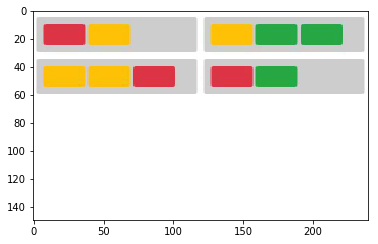

In [4]:
tags, images = load_dataset("toy")
print("#examples", len(tags))
images = [shrink_img(img, 0.5).transpose((2, 0, 1)) for img in norm_rgb_imgs(images[:])]
plt.imshow(1 - images[0].transpose(1, 2, 0))

### Create datasets

#classes=84, #tags=1750


<BarContainer object of 84 artists>

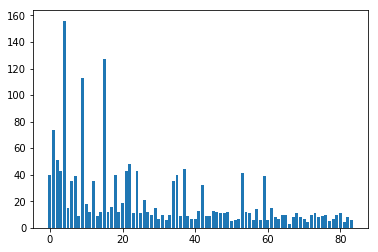

In [5]:
class2id = {}
classes = defaultdict(lambda: 0)
for tag in tags:
    nbtn_class, row_class, n_buttons, buttons, rows = tag2class(tag)    
    # create customize label
    ulbl = "-".join(rows)
#     ulbl = str(n_buttons)
#     ulbl = "-".join(str(buttons[x]) for x in sorted(buttons.keys()))
    if ulbl not in class2id:
        class2id[ulbl] = len(class2id)

    classes[class2id[ulbl]] += 1

print(f"#classes={len(class2id)}, #tags={len(tags)}")
x, y = list(zip(*classes.items()))
plt.bar(x, y)

In [6]:
nbtn_class2id, row_class2id = make_vocab(tags[:1250])
train_X, train_nbtn_y, train_row_y = make_dataset(images[:1250], tags[:1250], row_class2id, nbtn_class2id)
valid_X, valid_nbtn_y, valid_row_y = make_dataset(images[1250:1500], tags[1250:1500], row_class2id, nbtn_class2id)
test_X, test_nbtn_y, test_row_y = make_dataset(images[1500:], tags[1500:], row_class2id, nbtn_class2id)

datasets = {
    "train": (train_X, train_row_y, train_nbtn_y),
    "valid": (valid_X, valid_row_y, valid_nbtn_y),
    "test": (test_X, test_row_y, test_nbtn_y),
}

### Define the model

In [60]:
class CNNToyFeature(nn.Module):

    def __init__(self, img_h: int, img_w: int, n_class_task1: int, n_class_task2: int):
        super().__init__()
        self.img_w = img_w
        self.img_h = img_h

        self.n_class_task1 = n_class_task1
        self.n_class_task2 = n_class_task2
        self.__build_model()

    def __build_model(self):
        # network compute features of target image
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=2)
        self.bn1 = nn.BatchNorm2d(16, momentum=0.9)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm2d(32, momentum=0.9)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(64, momentum=0.9)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        imgsize = [self.img_h, self.img_w]
        for i, s in enumerate(imgsize):
            s = conv2d_size_out(s, 7, 2)
            s = pool2d_size_out(s, 3, 2)
            s = conv2d_size_out(s, 5, 1)
            s = pool2d_size_out(s, 3, 2)
            s = conv2d_size_out(s, 5, 1)
            s = pool2d_size_out(s, 3, 2)
            imgsize[i] = s
        
        linear_input_size = imgsize[0] * imgsize[1] * 64
        
        self.fc1 = nn.Linear(linear_input_size, 300)
        self.fc1_bn = nn.BatchNorm1d(500, momentum=0.9)
        self.fc1_dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(500, 250)
        self.fc2_bn = nn.BatchNorm1d(250, momentum=0.9)
        self.fc2_dropout = nn.Dropout(p=0.6)
        self.repr_size = 300
        self.task1 = nn.Linear(self.repr_size, self.n_class_task1)
        self.task2 = nn.Linear(self.repr_size, self.n_class_task2)
        
    def forward(self, X):
        # X is N x C x W x H
        X = self.pool1(F.selu(self.conv1(X)))
        X = self.pool2(F.selu(self.conv2(X)))
        X = self.pool3(F.selu(self.conv3(X)))
        
        # flatten to N x (C * W * H)
        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))
        # X = F.relu(self.fc1_dropout(self.fc1(X)))
        # X = F.relu(self.fc2(X))
        return X
        
    def forward_task1(self, X):
        X = self.forward(X)
        return F.log_softmax(self.task1(X), dim=1)
    
    def forward_task2(self, X):
        X = self.forward(X)
        return F.log_softmax(self.task2(X), dim=1)

In [61]:
model = CNNToyFeature(img_h=150, img_w=240, n_class_task1=len(row_class2id), n_class_task2=len(nbtn_class2id)).to(device)
print(model.eval())
model.train()

loss_func = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

task1_histories, task2_histories = train(model, loss_func, loss_func, scheduler, optimizer, datasets, n_epoches=100, batch_size=100, device=device)

3200
CNNToyFeature(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=300, bias=True)
  (fc1_bn): BatchNorm1d(500, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (fc1_dropout): Dropout(p=0.3)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc2_bn): BatchNorm1d

In [9]:
len(row_class2id)

84

In [22]:
optimizer

Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.005
    lr: 0.00125
    weight_decay: 0
)